# Must-Know Graph Algorithms in Python

In this notebook we will learn about some of the fundamental graph algorithms used in network science using the Networkx library.




In [308]:
import networkx as nx
import random
import itertools
import sys

from matplotlib import pyplot as plt
import matplotlib.colors as mcolors

## Betweeness-Centrality

The betweenness-centrality metric yields insight into how "important" a node is in the graph. In real-world applications, betweenness-centrality is used to identify nodes that have the most influence to the structure of the network that could be superspreaders of disease or ideal candidates for an advertisment campaign. These nodes have a significant control over edge-based information passing between other nodes in the graph. The metric is calculated for each node $v$ by summing the ratio of the number of shortest paths between all node pairs $s\neq v\neq t$ that pass through $v$, over all shortest paths between $s$ and $t$. If a node is often found in the shortes path between lots of other nodes, it will have a high betweenness centrality. 

Let us use Networkx to calculate the betweenness-centrality of nodes in a real-world network dataset of neurons and synapses in C. elegans (a type of worm). We will visualise the network and plot node sizes according to their $C$ value. The larger the circle, the higher the betweenness-centrality and the more shortest paths that pass through the node.


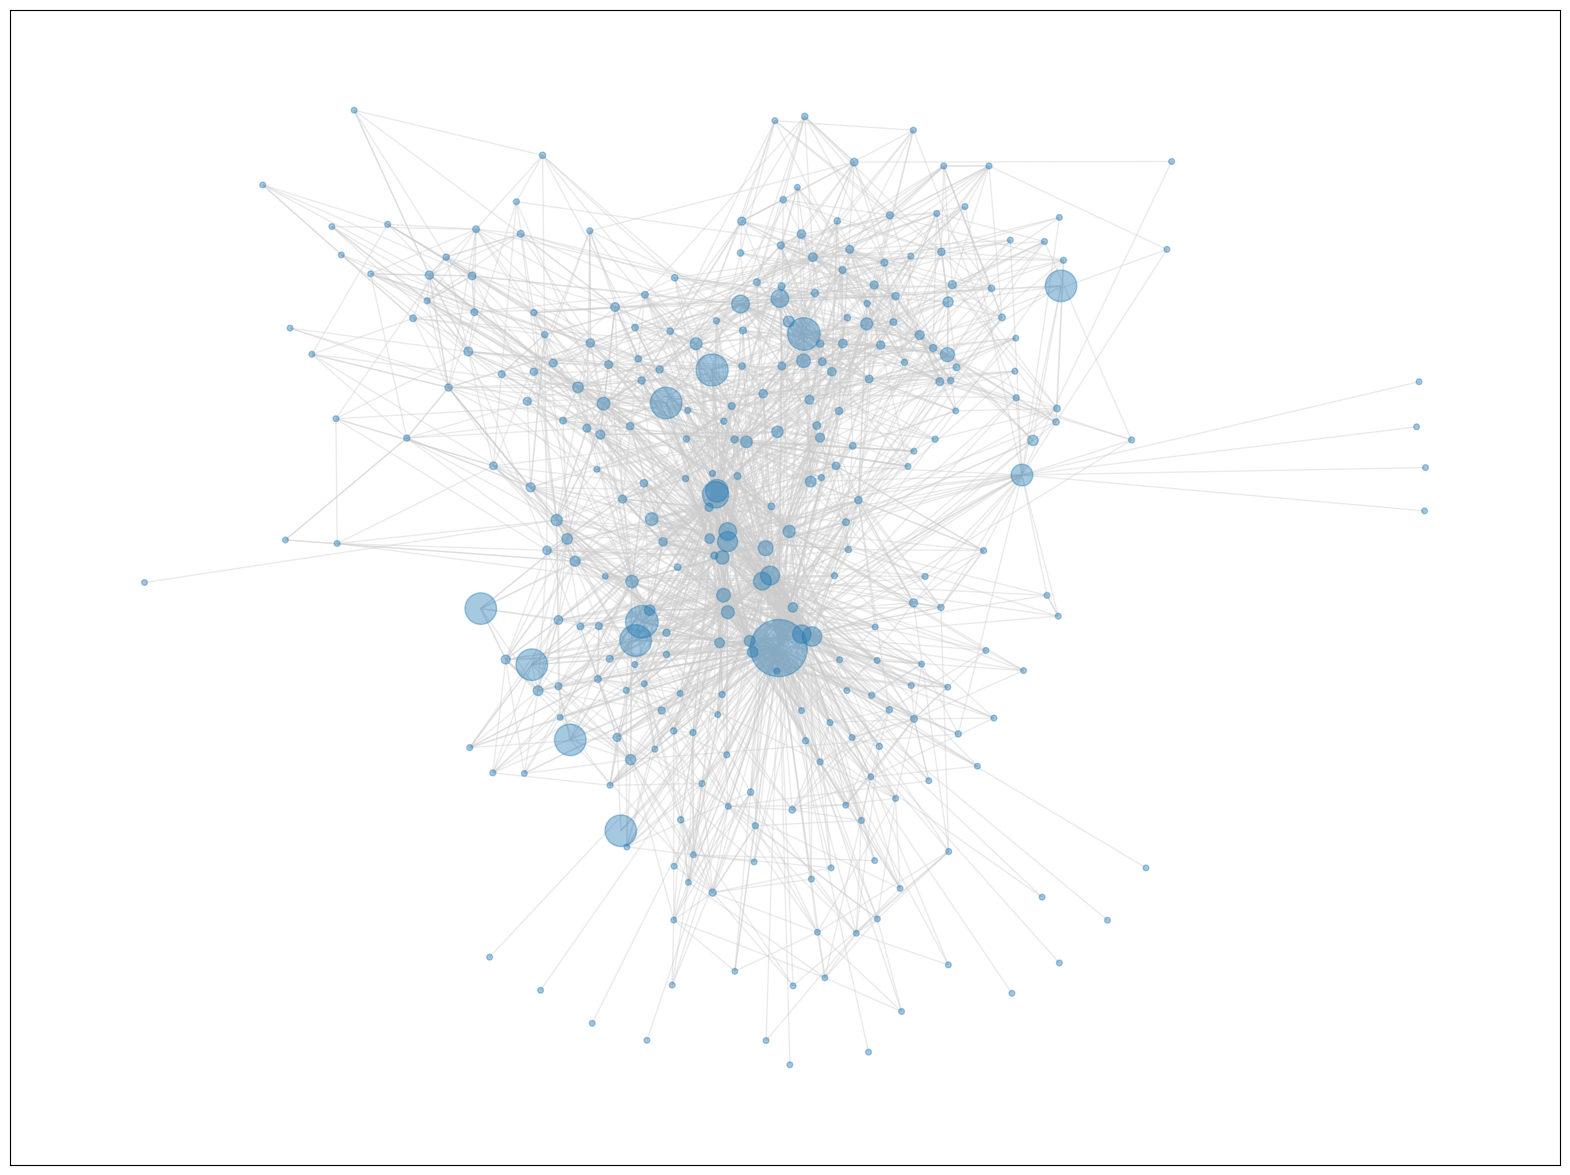

In [158]:
# read the network from the dataset (GML file)
G = nx.read_gml("celegansneural.gml")

# grab the largest connected component
components = nx.connected_components(G)
largest_component = max(components, key=len)
H = G.subgraph(largest_component)

# compute centrality using networkx
centrality = nx.betweenness_centrality(H, k=10, endpoints=True)

# visualize the network using a spring-layout algorithm and
# set the node size according to the centrality values C(v)
pos = nx.spring_layout(H)
node_size = [v * 5000 for v in centrality.values()]

plt.figure(figsize=(20, 15))
nx.draw_networkx(
    H,
    pos=pos,
    with_labels=False,
    node_size=node_size,
    edge_color="0.8",
    alpha=0.4,
)

plt.show()


## Biconnected components

A biconnected component is a maximal (largest) subgraph such that the removal of a node (and all edges incident on that node) will not disconnect the subgraph. This means that there are always two non-intersecting paths between any node pair in the component. Nodes may belong to multiple biconnected components; and those that do are called cut nodes. Any connected graph decomposes into a tree of biconnected components called the block-cut tree of the graph. Despite sounding a bit abstract, it is often very useful to perform this decomposition to graphs as the resulting block tree yields information about the structure of the original graph. If we were to remove a cut node from the graph, we would destroy the local block structure and create smaller components in its place. This means that the cut node is important in order to keep that local region connected together. Within the biconnected component itself however, there are no cut nodes, as there are at least two paths keeping the nodes connected within this subgraph. 

The identification of biconnected components is crucial for applications that have to maintain structure, such as road networks or computer networks. They also indicate how robust a portion of the graph is to random attack of its nodes. For instance, if a node within a biconnected component is removed from the network, traffic can still reach its destination via an alternative path; however, if a cut node is removed, we lose connectivity. 

Let us create a network and use networkx to find its biconnected components. We will then plot the components next to the original graph.

In [159]:

G = nx.Graph()

G.add_edge(0, 1)
G.add_edge(1, 2)
G.add_edge(1, 3)
G.add_edge(2, 3)
G.add_edge(2, 4)
G.add_edge(3, 4)
G.add_edge(1, 5)
G.add_edge(0, 6)
G.add_edge(5, 6)
G.add_edge(5, 7)
G.add_edge(5, 8)
G.add_edge(7, 8)
G.add_edge(8, 9)
G.add_edge(10, 11)

components = list(nx.biconnected_components(G))
components

[{1, 2, 3, 4}, {8, 9}, {5, 7, 8}, {0, 1, 5, 6}, {10, 11}]

In [160]:
# create a graph from all of the biconnected components 
U = nx.Graph()
for c in components:
    U = nx.disjoint_union(U, G.subgraph(c))

# sort the labels out so the new union graph match the original one
labels={
    0 : 1, 1 : 2, 2 : 3, 3 : 4,
    4 : 10, 5 : 11,
    6 : 5, 7 : 7, 8 : 8,
    9 : 0, 10 : 1, 11 : 5, 12 : 6,
    13 : 8, 14 : 9,
}

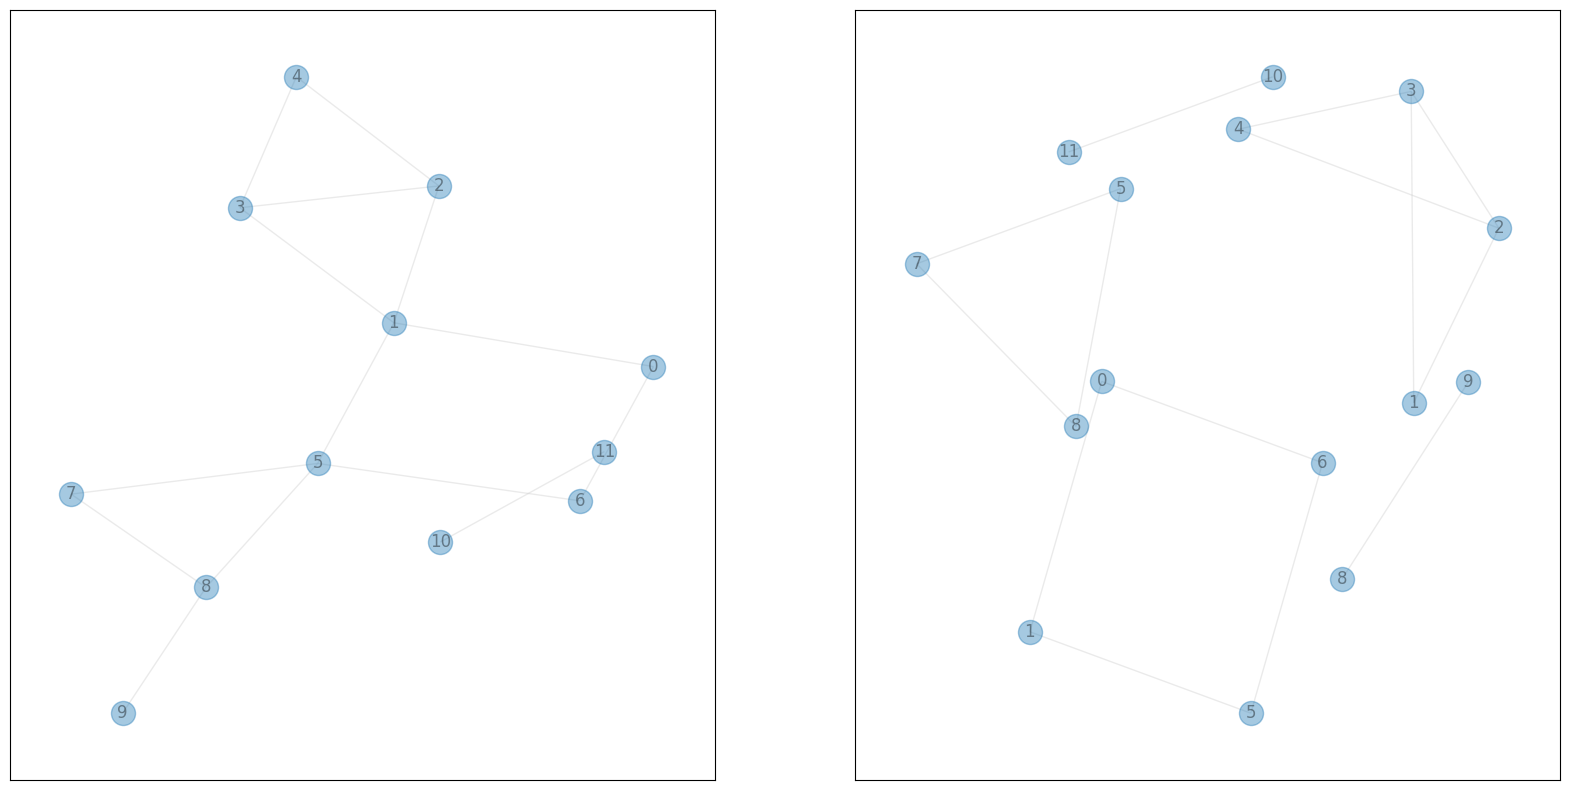

In [161]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))

# draw the original graph
nx.draw_networkx(
    G,
    pos=nx.kamada_kawai_layout(G),
    with_labels=True,
    edge_color="0.8",
    node_size=300,
    alpha=0.4,
    ax=ax1
)

# draw the biconnected component blocks
nx.draw_networkx(
    U,
    pos=nx.kamada_kawai_layout(U),
    with_labels=True,
    edge_color="0.8",
    node_size=300,
    labels=labels,
    alpha=0.4,
    ax=ax2
)

The left hand graph is the original network with its nodes labelled from 0 to 11. The right hand network is drawing of the biconnected components of the original network. We can see that cut nodes are repeated across all of the components that they belong to, for instance, node 1 belongs to both 4-cycles.

## Bridges (cut edges)

Bridges or "cut edges" in a graph are edges whose deletion increases the graph's number of connected components. As such they often make excellent targets for dismantling a network as fast as possible by preferentially deleting those edges. To examine this, we will create a random network and find its cut edges. We will then perform two experiments: i) remove edges at random from the entire network, ii) remove cut edges at random from the network, and compare the size of the largest connected component remaining in the graph.


In [162]:
def get_largest_component_subgraph(G: nx.Graph) -> nx.Graph:
    """
    Given a networkx graph, return the largest connected component
    as a subgraph.
    """
    components = nx.connected_components(G)
    largest_component = max(components, key=len)
    return G.subgraph(largest_component)


def experiment(N: int, kmean: int, only_bridges: bool, num_repeats: int = 20):
    """
    Perform the experiment and return the results.
    
    :param N: the size of the network
    :param kmean: the mean degree of the network
    :param only_bridges: if true only remove bridge edges
    :param num_repeats: number of repeats to conduct

    :returns dict: a dictionary containing the largest connected component size
                   and the distribution of connected component sizes.
    """

    results = []
    for repeat in range(num_repeats):

        G = nx.fast_gnp_random_graph(N, kmean / N)          # Erdos-Renyi graph
        G: nx.Graph = get_largest_component_subgraph(G)     # only retain the largest connected component
        G = G.copy()
    
        bridges = list(nx.bridges(G))                       # find all bridges in the graph
        num_remove_edges = len(bridges)                     # number of edges to remove during each repeat

        # remove some edges from the graph
        if only_bridges:
            edges = bridges
        else:
            edges = G.edges()

        es = random.sample(list(edges), num_remove_edges)
        G.remove_edges_from(es)

        # store the size of the largest connected component
        results.append(len(get_largest_component_subgraph(G)))

    # return the results
    return {'largest_component_size' : results}


N = 50000                       # number of nodes in the graph
kmean = 2.25                    # mean degree

# conduct the two experiments
random_results = experiment(N, kmean, False)
targeted_results = experiment(N, kmean, True)


/var/folders/9x/hnb8fg0x2p1c9p69p_70jnn40000gq/T/ipykernel_75581/1887580318.py:18: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(["", x1, "", x2])


Text(0, 0.5, 'Size of the giant component')

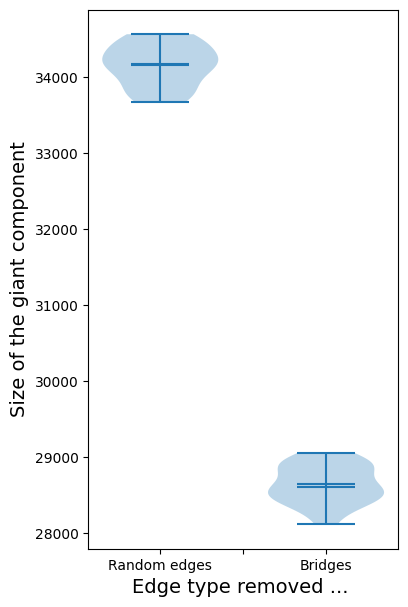

In [163]:
x1 = 'Random edges'
x2 = 'Bridges'
y1 = random_results['largest_component_size']
y2 = targeted_results['largest_component_size']

ax = plt.figure(figsize=(4,7)).gca()

ax.violinplot(
    [y1, y2],
    [1,2],
    widths=0.7,
    showmeans=True,
    showextrema=True,
    showmedians=True
 )


ax.set_xticklabels(["", x1, "", x2])

plt.xlabel('Edge type removed ... ', fontsize = 14)
plt.ylabel('Size of the giant component', fontsize = 14)

As we expected, targeting bridge edges dismantles the network moreso than removal of an equivalent number of random edges, leading to a reduction in the size of the largest connected component. This highlights the structural importance of bridges in keeping the network connected!

## Community detection algorithms

Communities in networks are groups of nodes that are densely connected within the group, but have few connections outside the group. A community detection algorithm is a way to assign nodes to communities. 

The Girvan-Newman algorithm is a community detection algorithm that works by iteratively removing edges that have the highest number of shortest paths between node pairs passing through them. As edges are successively removed, the network fractures into smaller pieces: the communities! Let's load in a real-world dataset from Networkx, the Karate club network, and use the Girvan-Newman algorithm to detect the community structure. Given that the algorithm is an iterative process, it is up to us to determine how many communities we want to break the network into. The implementation of the Girvan-Newman algorithm in networkx yields a Python generator over iterations, such that if an iteration has $m$ communities, then the `next()` iteration has $m+1$. As such, we use `itertools.takewhile` to take the next values from the generator while the number of communities is less than or equal to some cutoff value $k$. At the final iteration, when we have exactly $k$ communities, we store these values in a list called `node_groups` and plot each group of nodes the algorithm has found below.

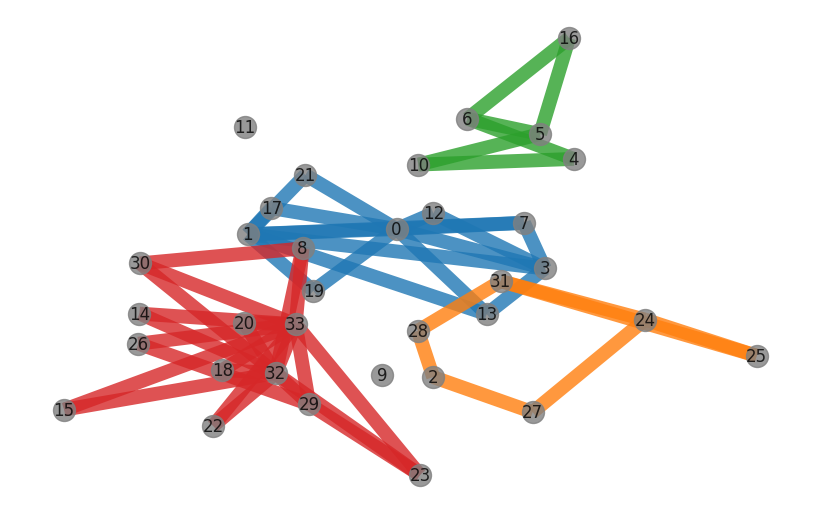

In [279]:
# Use Girvan-Newman algorithm to find communities
G = nx.karate_club_graph()
k = 6
node_groups = []
comp = nx.community.girvan_newman(G)
limited = itertools.takewhile(lambda c: len(c) <= k, comp)
for communities in limited:
    if len(communities) == k:
        node_groups.append(tuple(sorted(c) for c in communities))

# plot the communities
plt.figure(figsize=(8, 5))
colours = list(mcolors.TABLEAU_COLORS.keys())
for i, com in enumerate(node_groups[0]):
    
    nx.draw(
        G.subgraph(com),
        with_labels=True,
        pos=nx.kamada_kawai_layout(G),
        node_color="0.5",
        edge_color=colours[i],
        node_size=250,
        width=10,
        alpha=0.8,
    )

plt.show()

## Clique Detection

The Bron-Kerbosch algorithm can be used to find the maximal cliques in a graph. It works by maintaining three disjoint sets of nodes R, P and X. It creates a search tree by choosing a node from the graph and attempting to expand it into a clique until it cannot go further. At this point either it will have found a new clique (which it reports) or the clique it found will belong to an already reported larger clique. It then backtracks to the last node it chose and returns the disjoint sets to their value at this level of the recursion before the choice and expands in a new direction.

In more detail, we begin with $P$ containing all nodes in the graph, whilst $R$ and $X$ are empty sets. We select a node, $v$, from $P$ and add it to $R$, removing its non-neighbors from $P$ and $X$. Then pick another vertex from the new $P$ set and repeat the process until $P$ is empty. When $P$ is empty, if $X$ is empty then we report the nodes contained in $R$ as a new maximal clique. If $X$ is not empty then $R$ contains a subgraph of an already found larger clique. The algorithm then backtracks to the last node it chose and restores $P$ ,$R$ and $X$ as they were before the choice, removing the node from $P$ and adding it to set $X$, before expanding to the next node. The process continues until $P$ is empty and all nodes in the search tree have been visited, at which point it terminates.

In [361]:
def Bron_Kerbosch_algorithm(G: nx.Graph, R: set, P: set, X: set, results):
    
    # if P and X are both empty sets, record the clique
    if not any([P,X]):
        results.append(tuple(sorted(R)))

    # while P isn't empty ...
    while P:
        # grab a node in P and remove it from P ... 
        v = P.pop()

        # grab the set of neighbours of v
        ns = set(G.neighbors(v))
       
        # recurse down the search tree
        # add v to R
        # P --> nodes that are both currently unexpanded AND neighbours of v.
        # X --> keep only nodes that are pruned AND neighbours of v.
        Bron_Kerbosch_algorithm(G, R.union([v]), P.intersection(ns), X.intersection(ns), results)

        # add v to the pruned set
        X.add(v)


In [362]:
G = nx.karate_club_graph()

# initialise data structures for Bron-Kerbosch and call
R, P, X, results = set(), set(G.nodes()), set(), list()
Bron_Kerbosch_algorithm(G, R, P, X, results)

# call the networkx version 
nx_results = [tuple(sorted(c)) for c in list(nx.find_cliques(G))]

# compare the results are the same
set(results) == set(nx_results)

True